## Import Packages

In [69]:
# Import packages
%matplotlib inline

from surprise import Reader
from surprise import SVD,SVDpp, NMF, NormalPredictor
from surprise import KNNBasic
from surprise import Dataset
from surprise import Trainset
from surprise import accuracy
from surprise.model_selection import LeaveOneOut
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from itertools import combinations
from collections import defaultdict
import random
import copy
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [70]:
np.random.seed(0)
random.seed(0)
warnings.filterwarnings('ignore')

## Define Working Directory

In [71]:
path_clean_data = '/Users/jericojohns/Desktop//W207/W207_movies/data/clean_data/'

## Import Prepocessed Data 

#### TEMPORARY SECTION. 

In [72]:
# def filter_ratings(df, min_ratings):
    
#     '''Filter users with num_ratings below min_ratings
#     params: df, min_ratings
#     return: sorted_filtered_df
#     '''
    
#     # Value counts of user ratings
#     user_ratings_counts = df['userId'].value_counts()
#     # List of users with ratings counts greater than min_ratings
#     filtered_users = user_ratings_counts[user_ratings_counts >= min_ratings].index
#     # Filter df to list of users above
#     filtered_df = df[df['userId'].isin(filtered_users)]
    
#     return filtered_df

In [73]:
# def train_dev_test_split(ratings_df, dev_size=1, test_size=1):
    
#     '''
#     Split user ratings data into train, development and test sets holding the last 
#     [test_size] ratings per user for test and last [dev_size] ratings per user for 
#     development, following reverse chronological order
    
#     Parameters
#     ----------
#     ratings_df : A dataframe of ratings data
#     dev_size : The number of ratings per user to set asside development data
#     test_size : The number of ratings per user to set asside test data
    
#     Returns
#     -------
#     train_df : Dataframe of training ratings data
#     dev_df : Dataframe of development ratings data
#     test_df :  Dataframe of test ratings data
#     '''
    
#     # Add a column that ranks each rating in reverse chronolgical grouped by user
#     ratings_df['rank'] = ratings_df.groupby(['userId'])['timestamp'] \
#                          .rank(method='first', ascending=False).copy()
    
#     # Filter to test data using rank column
#     test_df = ratings_df[ratings_df['rank'].isin(range(1,1+test_size))][['userId', 'movieId', 'rating']]
    
#     # Filter to dev data using rank column
#     dev_df = ratings_df[ratings_df['rank'].isin(range(1+test_size, 1+test_size+dev_size))][['userId', 'movieId', 'rating']]
    
#     # Filter to train data using rank column
#     train_df = ratings_df[ratings_df['rank'] >= (1+test_size+dev_size)][['userId', 'movieId', 'rating']]
        
#     return train_df, dev_df, test_df

In [74]:
# def create_evaluation_pools(train_df, test_df, pool_size=100):
    
#     '''
#     Create pools of movies to evaluate the collaborative filtering models.
#     Each pool will contain pool_size movies per user. Each pool includes the 
#     movies in the test_df and randomly selects the rest of the movies from 
#     those not watched by the user.
    
#     Parameters
#     ----------
#     train_df : A dataframe of the training ratings data
#     test_df : A dataframe of the test ratings data
#     pool_size : The size of each movie pool
    
#     Returns
#     -------
#     evaluation_pools_dict : A dictionary from user to the pool of movies on 
#                             which to evaluate the recommender system
    
#     '''
    
#     # Find the list of unique users and movies in the training data
#     users = set(train_df['userId'].unique())
#     movies = set(train_df['movieId'].unique())
    
#     # Instantiate the output dictionary
#     evaluation_pools_dict = {}
    
#     # Loop through each user
#     for user in users:
        
#         # Find set of movies rated by the user in the training and test data
#         train_movies = set(train_df[train_df['userId']==user]['movieId'])
#         test_movies = set(test_df[test_df['userId']==user]['movieId'])
        
#         # Find the set of movies not rated by the user
#         movies_not_rated = movies - train_movies - test_movies
        
#         # Randomly sample movies from the movies not rated by the user
#         n_movies_to_choose = pool_size - len(test_movies)
#         sample_movies_not_rated = set(random.sample(movies_not_rated, n_movies_to_choose))
        
#         # Combine the test movies with the random sample of movies
#         evaluation_pool = list(test_movies | sample_movies_not_rated)
        
#         # Add each evaluation_pool to the output dictionary 
#         evaluation_pools_dict[user] = evaluation_pool
    
#     return evaluation_pools_dict

In [75]:
#Load data into ratings_df. 
# ratings_df = pd.read_csv("/Users/jericojohns/Desktop/W207/data/ratings_small.csv", low_memory=False)

In [76]:
# #TEMPORARY
# #Filter our user list to those users who have 30+ ratings
# filtered_data = filter_ratings(ratings_df, min_ratings = 30)

# #Now split our data so that we take the n-1 (most recent) rating as our test rating, 
# #and n-2 (second most recent) rating as our dev rating 
# train_df, dev_df, test_df = train_dev_test_split(filtered_data)

# dev_evaluation_pools = create_evaluation_pools(train_df, dev_df)
# test_evaluation_pools = create_evaluation_pools(train_df, test_df)

# #Create a surprise Reader object to help us create a Surprise DataSet object. 
# reader = Reader()

# #Now we load training data as is (no folding) by calling the .build_full_trainset() method. 
# train_data = Dataset.load_from_df(train_df, reader).build_full_trainset()


# #Convert dev_data to DataSet object, and then as testset object by calling .buildtestset()
# dev_data = Dataset.load_from_df(dev_df, reader).build_full_trainset()
# dev_data = dev_data.build_testset()

# #Convert test_data to DataSet object, and then as testset object by calling .buildtestset()
# test_data = Dataset.load_from_df(test_df, reader).build_full_trainset()
# test_data = test_data.build_testset()

In [77]:
# Load train, dev, test data
train_df = pd.read_csv(path_clean_data + "cf_train_ratings.csv", low_memory=False)
dev_df = pd.read_csv(path_clean_data + "cf_dev_ratings.csv", low_memory=False)
test_df = pd.read_csv(path_clean_data + "cf_test_ratings.csv", low_memory=False)

In [78]:
# drop 'Unnamed 0' column
train_df.drop('Unnamed: 0', axis=1, inplace=True)
dev_df.drop('Unnamed: 0', axis=1, inplace=True)
test_df.drop('Unnamed: 0', axis=1, inplace=True)

In [79]:
# Inspect train_df
train_df.head()

,userId,movieId,rating
0,4,223,4.0
1,4,415,4.0
2,4,648,4.0
3,4,1097,5.0
4,4,1197,4.0


In [80]:
#Load dev and test evaluation pools
f1 = open(path_clean_data + 'dev_evaluation_pools.json',)
f2 = open(path_clean_data + 'test_evaluation_pools.json',)
dev_evaluation_pools = json.load(f1)
test_evaluation_pools = json.load(f2)

# Convert key from str to int
dev_evaluation_pools = {int(k):v for k,v in dev_evaluation_pools.items()}
test_evaluation_pools = {int(k):v for k,v in test_evaluation_pools.items()}

In [81]:
#Create empty global lists to append our results
algo_list = [] 
hr_list = []
hr_cutoff_list = [] 
avg_est_rating_list = []
avg_novelty_list = []
rmse_list = []

## Load Data into Surprise Data Structures

In [82]:
#Create a surprise Reader object to help us create a Surprise DataSet object. 
reader = Reader()

#Now we load training data as is (no folding) by calling the .build_full_trainset() method. 
train_data = Dataset.load_from_df(train_df, reader).build_full_trainset()

#Convert dev_data to DataSet object, and then as testset object by calling .buildtestset()
dev_data = Dataset.load_from_df(dev_df, reader).build_full_trainset()
dev_data = dev_data.build_testset()

#Convert test_data to DataSet object, and then as testset object by calling .buildtestset()
test_data = Dataset.load_from_df(test_df, reader).build_full_trainset()
test_data = test_data.build_testset()

## Run and Evaluate Matrix Factorization Models

### Define Custom Functions

In [83]:
def calculateItemNovelty(ratings_df):
    '''Create two lists of 1.) sc_rankings (standardized and minMaxScaled)
    and 2.) movieIDs that correspond to those rankings.'''
    rankings = ratings_df["movieId"].value_counts()
    ratings =  ratings_df[['movieId','rating']].groupby('movieId').mean()

    #Let's standardize our rankings to be able to be used together 
    scaler = MinMaxScaler(feature_range = (0,5))
    scaler2 = RobustScaler()
    ranking_movieID = rankings.index.to_numpy()
    ratings = ratings.to_numpy().reshape(-1,1)

    scaler.fit(ratings)
    scaler2.fit(ratings)
    sc_rankings = rankings.to_numpy().reshape(-1,1)
    sc_rankings = scaler2.transform(sc_rankings)
    sc_rankings = scaler.fit_transform(sc_rankings)



    sc_rankings = sc_rankings.tolist()

    sc_rankings = [(float(i[0])*-1)+5 for i in sc_rankings]


    ranking_movieID = ranking_movieID.tolist()
    
    return sc_rankings, ranking_movieID

In [84]:
def sort_evaluation_pools(model, evaluation_pools, ranking_list, ranking_movies):
    '''
    Take evaluation pool for each user and sort it based on ratings predicted by a 
    trained model in descending order of predicted ratings
    Parameters
    ----------
    model : A trained surprise model
    evaluation_pools : A dictionary from user to the pool of movies on 
                       which to evaluate the recommender system 
    ranking_list = movie novelty scores
    ranking_movies = movieIDs tied to novelty scores
    
    Returns
    -------
    sorted_evaluation_pools : A dictionary from user to the pool of movies where each 
                              movie is sorted in descending order of predicted movie 
                              rating
    '''
    
    # Instantiate output dictionary
    sorted_evaluation_pools = {}
    
    # Loop through each key-value pair in the input dictionary
    for user, movie_pool in evaluation_pools.items():
        
        # Create a dictionary for the predicted rating of each movie in the user's pool
        predictions = {}
        for movie in movie_pool:
            pred = model.predict(user, movie)
            try: 
                novelty = ranking_list[ranking_movies.index(movie)]
            except: 
                novelty = 5
            predictions[movie] = (pred[3],novelty)
            #Add in the novelty score
            
        
        # Sort the pool in descending order of predicted ratings
        sorted_pool = [(k,v) for k, v in sorted(predictions.items(), key=lambda item: item[1], reverse=True)]
        
        # Add key-value pair of user and sorted evalualtion pool to the output dictionary
        sorted_evaluation_pools[user] = sorted_pool
        
        #Finally reformat our dictionary to be in format userID: (movieID, rating, novelty)
        final_pool = defaultdict(list)
        for userID in sorted_evaluation_pools: 
            for movieID, tup in sorted_evaluation_pools[userID]: 
                final_pool[int(userID)].append((int(movieID), tup[0], tup[1]))


    return final_pool

In [85]:
def calc_hit_rate_pools(sorted_evaluation_pools, test_df, top_n=10):
    '''
    Calculate hit rate given a dictionary of sorted evaluation pools and the corrsponding 
    test data frame. A hit is defined as finding a test movie in the top_n of sorted 
    evalutation pool of a user
    Parameters
    ----------
    sorted_evaluation_pools : A dictionary from user to the pool of movies where each 
                              movie is sorted in descending order of predicted movie 
                              rating
    test_df : A dataframe of ratings for movies being tested in the evaluation pools
    top_n : The threshold above which a test movies should be found to be called a hit
    
    Returns
    -------
    hit_rate : A hit rate across pools
    
    '''
    
    # Start with hits and totals at 0
    hits=0
    total=0
    
    # Loop through the each key-value pair in the input dictionary
    for user, sorted_pool in sorted_evaluation_pools.items():
        
        # Filter to test movies for the user
        test_movies = test_df[test_df['userId']==user]
        
        # Find top_n movies from the pool
        top_movies = sorted_pool[:top_n]
        
        # Loop through each test movie
        for index, test_movie in test_movies.iterrows():
            test_movie_id = test_movie['movieId']
            
            # If test movie is in top_movies, then add one to hits
            for movie, rating, novelty in top_movies: 
                if test_movie_id == movie:
                    hits += 1
                
            # Add one to total for each test movie  
            total += 1
     
    hit_rate = hits/total
    return hit_rate

In [86]:
def calc_hit_rate_pools_with_cutoff(sorted_evaluation_pools, test_df, top_n=10, rating_cutoff=0):
    '''
    Calculate hit rate given a dictionary of sorted evaluation pools and a corresponding 
    test data frame. A hit is defined as finding a test movie that has a rating greater 
    than a rating_cutoff in the top_n of sorted evalutation pool of a user.
    Parameters
    ----------
    sorted_evaluation_pools : A dictionary from user to the pool of movies where each 
                              movie is sorted in descending order of predicted movie 
                              rating
    test_df : A dataframe of ratings for movies being tested in the evaluation pools
    top_n : The threshold above which a test movies should be found to be called a hit
    rating_cutoff : The threshold rating above which a test movie should be evaluated
    
    Returns
    -------
    hit_rate : A hit rate across pools
    '''
    
    # Start with hits and totals at 0
    hits=0
    total=0
    
    # Loop through the each key-value pair in the input dictionary
    for user, sorted_pool in sorted_evaluation_pools.items():
        
        # Filter to test movies for the user
        test_movies = test_df[test_df['userId']==user]

         # Find top_n movies from the pool
        top_movies = sorted_pool[:top_n]
        
        # Loop through each test movie
        for index, test_movie in test_movies.iterrows():
            test_movie_rating = test_movie['rating']
            test_movie_id = test_movie['movieId']
            
             # If test movie has a rating above rating_cutoff then evaluate
            if test_movie_rating >= rating_cutoff:
                
                # If test movie is in top_movies, then add one to hits
                # If test movie is in top_movies, then add one to hits
                for movie, rating, novelty in top_movies: 
                    if test_movie_id == movie:
                        hits += 1
                
                # Add one to total for each test movie
                total += 1

    return hits/total

In [87]:
def summaryStats(sorted_evaluation_pools, test_df, test_prediction, rating_cutoff = 4): 
    '''Calculate average novelty, average rating, and hit rate for the top 10 of final sorted_evaluation_pool.'''
    hit_rate_pools = calc_hit_rate_pools(sorted_evaluation_pools, test_df)
    hit_rate_pools_with_cutoff =  calc_hit_rate_pools_with_cutoff(sorted_evaluation_pools, test_df, rating_cutoff=rating_cutoff)
    rmse = accuracy.rmse(test_prediction, verbose = False)
    total_est_rating = 0 
    total_novelty = 0 
    total_items = 0 
    for userID in sorted_evaluation_pools.keys(): 
        for tup in sorted_evaluation_pools[userID][:10]: 
            total_est_rating += tup[1]
            total_novelty += tup[2]
            total_items += 1
    
    avg_est_rating  = total_est_rating / total_items
    avg_novelty = total_novelty / total_items
    
    return hit_rate_pools, hit_rate_pools_with_cutoff, avg_est_rating, avg_novelty, rmse 
        


In [88]:
def compareModels(models, train_data, dev_data, hyperparams = False): 
    '''For baseline model selection of matrix factorization models.
    Choose model that optimizes hit_rate_pools_with_cutoff.'''
    
    for algo in models: 
        #Print model type 
        print(type(algo).__name__)
        
        #Train our train_data (all user's that have liked 30+ movies, train on the n-2 movie set)
        algo.fit(train_data)
        dev_prediction = algo.test(dev_data)
        
        #Sort our evaluation pool, using the algo. 
        sorted_dev_evaluation_pools = sort_evaluation_pools(algo, dev_evaluation_pools, sc_rankings, ranking_movieID) 
        
        #Calculate summary stats for each model. 
        hit_rate_pools, hit_rate_pools_with_cutoff, avg_est_rating, avg_novelty, rmse = summaryStats(sorted_dev_evaluation_pools, dev_df, dev_prediction, rating_cutoff = 4)
        print(f'HR@10: {hit_rate_pools}')
        print(f'HR@10 w/ Cutoff: {hit_rate_pools_with_cutoff}')
        print(f'RMSE: {rmse}')
        print(f'AvgRating@10: {avg_est_rating}')
        print(f'AvgNovelty@10: {avg_novelty}')
        if hyperparams == False: 
            algo_list.append(type(algo).__name__)
        else: 
            algo_list.append('SVD w/ Hyperparam Tuning')
        hr_list.append(hit_rate_pools)
        hr_cutoff_list.append(hit_rate_pools_with_cutoff)
        avg_est_rating_list.append(avg_est_rating)
        avg_novelty_list.append(avg_novelty)
        rmse_list.append(rmse)
        

In [89]:
def bestHyperparams(n_factors, n_epochs, lr_all, reg_all): 
    '''Non-exhaustive (manual) search over hyperparam values to
    select the best hyperparam values for hit_rate_pools_with_cutoff.'''
    best_hr = 0
    best_n_factors = 0
    best_n_epochs = 0 
    best_lr_all = 0 
    best_reg_all = 0

    for n_factor in n_factors: 
        for n_epoch in n_epochs: 
            for lr in lr_all: 
                for reg in reg_all: 
                    algo = SVD(n_factors = n_factor, n_epochs = n_epoch, lr_all = lr, reg_all = reg)
                    algo.fit(train_data)
                    sorted_dev_evaluation_pools = sort_evaluation_pools(algo, dev_evaluation_pools, sc_rankings, ranking_movieID)
        

                    #Calculate the two hit rates
                    hit_rate_pools = calc_hit_rate_pools(sorted_dev_evaluation_pools, dev_df)
                    hit_rate_pools_with_cutoff = calc_hit_rate_pools_with_cutoff(sorted_dev_evaluation_pools, dev_df, rating_cutoff=4)

                    if hit_rate_pools_with_cutoff > best_hr: 
                        best_hr = hit_rate_pools_with_cutoff
                        best_n_factors = n_factor
                        best_n_epochs = n_epoch
                        best_lr_all = lr
                        best_reg_all = reg


    print(f'Best HR@10: {best_hr}')
    print(f'n_factors = {best_n_factors}, n_epochs = {best_n_epochs}, lr_all = {best_lr_all}, reg_all = {best_reg_all}')
    
    return best_n_factors, best_n_epochs, best_lr_all, best_reg_all


In [90]:
def GetTopNSplitPools(sorted_evaluation_pool):
    '''Get the top n predicted movie ratings for a given user, 
    the next n, and the rest of the evaluation pool. 
    Used to process sorted_evaluation_pool before 
    diversificationSwap().'''
    predictions = sorted_evaluation_pool
    topN = defaultdict(list)
    nextN = defaultdict(list)
    remainingN = defaultdict(list)
    
    #Select top_n and remaining_n
    for userID, movies in predictions.items():
        topN[int(userID)] = movies[:10]
        #Pull the next n items as the remainingN list 
        nextN[int(userID)] = movies[10:30]
        remainingN[int(userID)] = movies[30:]
        

    return topN, nextN, remainingN

In [91]:
def diversificationSwap(topNPredicted, nextNPredicted, remainingNPredicted, iterations = 1): 
    '''For iteration in desired number of iterations (hyperparam): 
    drop the lowest novelty item from the topN list and
    replace with the highest novelty item from the remainingN list.'''
    
    topNPredicted_temp = copy.deepcopy(topNPredicted)
    nextNPredicted_temp = copy.deepcopy(nextNPredicted)
    
    for i in range(iterations): 
        for userID in topNPredicted_temp.keys():
            #Create a boolean that indicates whether swap is found
            swap_top = False
            
            #Drop items from topN and add to remainingN
            min_ranking = 5 
            min_movieID = None
            min_rating = None
            
            for item in topNPredicted_temp[userID]:
                movieID = item[0]
                rating = item[1]
                rank = item[2]
                
                if rank < min_ranking: 
                    swap_top = True
                    min_ranking = rank
                    min_movieID = movieID
                    min_rating = rating
                    
                    
            #Now shuffle (only if swap is found)
            if swap_top == True: 
                nextNPredicted_temp[int(userID)].append((int(min_movieID), min_rating, min_ranking))
                topNPredicted_temp[int(userID)].remove((int(min_movieID), min_rating, min_ranking))
            
            #Create a boolean that indicates whether swap is found
            swap_bottom  = False
            
            #Add items to topN and drop from remainingN
            max_ranking = 0 
            max_movieID = None
            max_rating = None
            
            for item in nextNPredicted_temp[userID]:
                movieID = item[0]
                rating = item[1]
                rank = item[2]
                
                if rank > max_ranking: 
                    swap_bottom = True
                    max_ranking = rank
                    max_movieID = movieID
                    max_rating = rating
                    
            #Now shuffle (only if swap is found)
            if swap_bottom == True: 
                topNPredicted_temp[int(userID)].append((int(max_movieID), max_rating, max_ranking))
                nextNPredicted_temp[int(userID)].remove((int(max_movieID), max_rating, max_ranking))
    
    #Now drop the ranking as this isn't needed for hit rate calcs. 
    #topNPredicted_temp.update(item[:-1] for item in value[items] for value in topNPredicted_temp.values())
    #remainingNPredicted_temp.update(item[:-1] for item in value[items] for value in remainingNPredicted.values())
    final_sorted_pool = defaultdict(list)
    
    #Add the top predicted, diversified items to our final evaluation_pool
    for userID in topNPredicted_temp.keys(): 
        for item in topNPredicted_temp[userID]: 
            #To drop tuple value we must first convert to list since tuples are immutable. 
            final_sorted_pool[int(userID)].append((int(item[0]), item[1], item[2]))
            #final_topN[int(userID)].append(int(item[0]))
    
    #Add the next N 
    for userID in nextNPredicted_temp.keys(): 
        for item in nextNPredicted_temp[userID]: 
            #To drop tuple value we must first convert to list since tuples are immutable. 
            final_sorted_pool[int(userID)].append((int(item[0]), item[1], item[2]))
            #final_topN[int(userID)].append(int(item[0]))
    
    #Add the remaining (unswapped) N items to create the full diversified evaluation pool 
    for userID in remainingNPredicted.keys(): 
        for item in remainingNPredicted[userID]: 
            #To drop tuple value we must first convert to list since tuples are immutable. 
            final_sorted_pool[int(userID)].append((int(item[0]), item[1], item[2]))
        
    return final_sorted_pool
        

In [92]:
def diversificationSwapBlended(topNPredicted, nextNPredicted, remainingNPredicted, iterations = 1, w1 = 0.5, w2 = 0.5): 
    '''For iteration in desired number of iterations (hyperparam): 
    drop the lowest blended rating and novelty item from the topN list and
    replace with the highest blended rating and novelty item from the remainingN list.
    This methods approximate's a movie's 'Hidden Gem' score (i..e high rating, low ranking)'''
    
    
    topNPredicted_temp = copy.deepcopy(topNPredicted)
    nextNPredicted_temp = copy.deepcopy(nextNPredicted)
    
    for i in range(iterations): 
        for userID in topNPredicted_temp.keys():
            #Create a boolean that indicates whether swap is found
            swap_top = False
            
            #Drop items from topN and add to remainingN
            min_blended_rank = 5
            min_movieID = None
            min_rating = None
            
            for item in topNPredicted_temp[userID]:
                movieID = item[0]
                rating = item[1]
                rank = item[2]
                blended_rank = (w1*rating) + (w2*rank)
                
                if blended_rank < min_blended_rank: 
                    swap_top = True
                    min_blended_rank = blended_rank
                    min_movieID = movieID
                    min_ranking = rank
                    min_rating = rating
                    
                    
            #Now shuffle (only if swap is found)
            if swap_top == True: 
                nextNPredicted_temp[int(userID)].append((int(min_movieID), min_rating, min_ranking))
                topNPredicted_temp[int(userID)].remove((int(min_movieID), min_rating, min_ranking))
            
            #Create a boolean that indicates whether swap is found
            swap_bottom  = False
            
            #Add items to topN and drop from remainingN
            max_blended_rank = 0 
            max_movieID = None
            max_rating = None
            
            for item in nextNPredicted_temp[userID]:
                movieID = item[0]
                rating = item[1]
                rank = item[2]
                blended_rank = (w1*rating) + (w2*rank)
                
                if blended_rank > max_blended_rank: 
                    swap_bottom = True
                    max_blended_rank = blended_rank
                    max_ranking = rank
                    max_movieID = movieID
                    max_rating = rating
                    
            #Now shuffle (only if swap is found)
            if swap_bottom == True: 
                topNPredicted_temp[int(userID)].append((int(max_movieID), max_rating, max_ranking))
                nextNPredicted_temp[int(userID)].remove((int(max_movieID), max_rating, max_ranking))
    
    #Now drop the ranking as this isn't needed for hit rate calcs. 
    #topNPredicted_temp.update(item[:-1] for item in value[items] for value in topNPredicted_temp.values())
    #remainingNPredicted_temp.update(item[:-1] for item in value[items] for value in remainingNPredicted.values())
    final_sorted_pool = defaultdict(list)
    
    #Add the top predicted, diversified items to our final evaluation_pool
    for userID in topNPredicted_temp.keys(): 
        for item in topNPredicted_temp[userID]: 
            #To drop tuple value we must first convert to list since tuples are immutable. 
            final_sorted_pool[int(userID)].append((int(item[0]), item[1], item[2]))
            #final_topN[int(userID)].append(int(item[0]))
    
    #Add the next N 
    for userID in nextNPredicted_temp.keys(): 
        for item in nextNPredicted_temp[userID]: 
            #To drop tuple value we must first convert to list since tuples are immutable. 
            final_sorted_pool[int(userID)].append((int(item[0]), item[1], item[2]))
            #final_topN[int(userID)].append(int(item[0]))
    
    #Add the remaining (unswapped) N items to create the full diversified evaluation pool 
    for userID in remainingNPredicted.keys(): 
        for item in remainingNPredicted[userID]: 
            #To drop tuple value we must first convert to list since tuples are immutable. 
            final_sorted_pool[int(userID)].append((int(item[0]), item[1], item[2]))
        
    return final_sorted_pool

In [93]:
def calcDiversityTradeoff(topNPredicted_Split, nextNPredicted_Split,remainingNPredicted_Split, test_df, test_prediction):
    '''Plot our novelty / HR@10 tradeoff by increasing number of iterations of our 
    diversificationSwap.'''
    method = []
    average_novelty = [] 
    hit_rate = [] 

    method_blended = []
    average_novelty_blended = []
    hit_rate_blended = []

    hit_rate_cutoff = []
    hit_rate_cutoff_blended = [] 

    swapping_iterations = []
    swapping_iterations_blended = []

    for i in range(0,6): 
        diversified_evaluation_pools = diversificationSwap(topNPredicted_Split, nextNPredicted_Split, remainingNPredicted_Split, iterations = i)
        diversified_evaluation_pools_blended = diversificationSwapBlended(topNPredicted_Split, nextNPredicted_Split, remainingNPredicted_Split, iterations = i, w1 = 0.7, w2 = 0.3)
        hit_rate_diversified_pools, hit_rate_diversified_pools_with_cutoff, avg_est_rating, avg_novelty, rmse = summaryStats(diversified_evaluation_pools, test_df, test_prediction, rating_cutoff = 4)
        hit_rate_diversified_pools_blended, hit_rate_diversified_pools_with_cutoff_blended, avg_est_rating_blended, avg_novelty_blended, rmse_blended = summaryStats(diversified_evaluation_pools_blended, test_df, test_prediction, rating_cutoff = 4)
        model = 'Matrix Factorization with SVD()'
        blended_model = 'Matrix Factoriziation with SVD(), blended swapping'

        method.append(model)
        method_blended.append(model)

        average_novelty.append(avg_novelty)
        average_novelty_blended.append(avg_novelty_blended)

        swapping_iterations.append(i)
        swapping_iterations_blended.append(i)

        hit_rate.append(hit_rate_diversified_pools)
        hit_rate_blended.append(hit_rate_diversified_pools_blended)

        hit_rate_cutoff.append(hit_rate_diversified_pools_with_cutoff)
        hit_rate_cutoff_blended.append(hit_rate_diversified_pools_with_cutoff_blended)

    
    return method, average_novelty, hit_rate, rmse, method_blended, average_novelty_blended, hit_rate_blended, rmse_blended, hit_rate_cutoff, hit_rate_cutoff_blended, swapping_iterations, swapping_iterations_blended

### Matrix Factorization Process

#### 1.) Calculate Item Novelty. 
##### We will use this in our sorted_evaluation_pools so that we don't need to pull-in novelty data everytime. 

In [94]:
#Calculate item (movieID) novelty. Store in 2 lists. 
sc_rankings, ranking_movieID = calculateItemNovelty(train_df)

(array([4.0000e+00, 3.0000e+00, 5.0000e+00, 1.6000e+01, 1.3000e+01,
        4.0000e+01, 7.4000e+01, 1.5300e+02, 4.7100e+02, 4.4099e+04]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

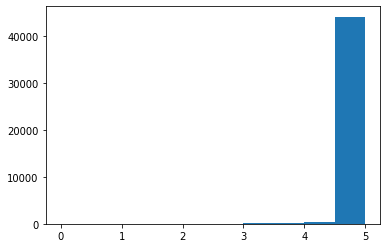

In [95]:
#View distribution
plt.hist(sc_rankings)

#### 2.) Test a baseline SVD() Model. 

In [96]:
# Train and test algorithm (Matrix Factorization for Collaborative Filtering)
algo = SVD()

# Train our train_data (all user's that have liked 30+ movies, train on the n-2 movie set)
algo.fit(train_data)
dev_prediction = algo.test(dev_data)

# Sort dev evaluation pools based on SVD model
sorted_dev_evaluation_pools = sort_evaluation_pools(algo, dev_evaluation_pools, sc_rankings, ranking_movieID)

#Get summary statistics that we will use across all models. 
hit_rate_pools, hit_rate_pools_with_cutoff, avg_est_rating, avg_novelty, rmse = summaryStats(sorted_dev_evaluation_pools, dev_df, dev_prediction, rating_cutoff = 4)

print(f'HR@10: {hit_rate_pools}')
print(f'HR@10 w/ Cutoff: {hit_rate_pools_with_cutoff}')
print(f'AvgRating@10: {avg_est_rating}')
print(f'AvgNovelty@10: {avg_novelty}')
print(f'RMSE: {rmse}')

KeyboardInterrupt: 

In [29]:
# Train and test random predictions as basline (NormalPredictor()). 
# "Algorithm predicting a random rating based on the distribution 
# of the training set, which is assumed to be normal."
algo = NormalPredictor()

# Train our train_data (all user's that have liked 30+ movies, train on the n-2 movie set)
algo.fit(train_data)
dev_prediction = algo.test(dev_data)

# Sort dev evaluation pools based on SVD model
sorted_dev_evaluation_pools = sort_evaluation_pools(algo, dev_evaluation_pools, sc_rankings, ranking_movieID)

#Get summary statistics that we will use across all models. 
hit_rate_pools, hit_rate_pools_with_cutoff, avg_est_rating, avg_novelty, rmse = summaryStats(sorted_dev_evaluation_pools, dev_df, dev_prediction, rating_cutoff = 4)

print(f'HR@10: {hit_rate_pools}')
print(f'HR@10 w/ Cutoff: {hit_rate_pools_with_cutoff}')
print(f'AvgRating@10: {avg_est_rating}')
print(f'AvgNovelty@10: {avg_novelty}')
print(f'RMSE: {rmse}')

HR@10: 0.09945750452079566
HR@10 w/ Cutoff: 0.0932475884244373
AvgRating@10: 4.968820532447686
AvgNovelty@10: 4.87571579264609
RMSE: 1.4325557216062068


#### 3.) Compare the three predominant Matrix Factorization Models and a Random Only Predictor. 

In [30]:
#Specify the 3 models
models = [NormalPredictor(), SVD(), SVDpp(), NMF()]
#Compare the 3 models, this will append results to global lists and print results. 
compareModels(models, train_data, dev_data, hyperparams = False)

NormalPredictor
HR@10: 0.0922242314647378
HR@10 w/ Cutoff: 0.11254019292604502
RMSE: 1.477030999034745
AvgRating@10: 4.9710381166500515
AvgNovelty@10: 4.8668799554874695
SVD
HR@10: 0.321880650994575
HR@10 w/ Cutoff: 0.3890675241157556
RMSE: 0.9565137049145211
AvgRating@10: 3.998925313443918
AvgNovelty@10: 4.52631914498999
SVDpp
HR@10: 0.321880650994575
HR@10 w/ Cutoff: 0.40514469453376206
RMSE: 0.9268431420068997
AvgRating@10: 4.024501445235358
AvgNovelty@10: 4.554275629433812
NMF
HR@10: 0.15009041591320071
HR@10 w/ Cutoff: 0.1607717041800643
RMSE: 0.9940485377566632
AvgRating@10: 4.397163200127645
AvgNovelty@10: 4.79301421152677


#### 4.) Do a non-exhaustive search for the best baseline model (SVD) hyperarameters. 

In [31]:
#Note default values n_factors = 100, n_epochs = 20, lr_all = 0.005, reg_all = 0.02
n_factors = [50, 100, 200, 500]
n_epochs = [10,20,30]
lr_all = [0.001, 0.005, 0.01]
reg_all = [0, 0.01, 0.02, 0.04]

best_n_factors, best_n_epochs, best_lr_all, best_reg_all = bestHyperparams(n_factors, n_epochs, lr_all, reg_all)

#### 5.) Apply our best hyperparams to our best baseline model. 

In [32]:
#Return the first 10 movies (in predicted rating) from the evaluation_pool, 
#and then the remaining n. We will use this structure to swap our predictions for diversity. 
model = [SVD(n_factors = best_n_factors, n_epochs = best_n_epochs, lr_all = best_lr_all, reg_all = best_reg_all)]
#model = [SVD(n_factors = 50, n_epochs = 10, lr_all = 0.005, reg_all = 0.04)]
#Compare Model. This will append results to our global lists. 
compareModels(model, train_data, dev_data, hyperparams = True)


SVD
HR@10: 0.3960216998191682
HR@10 w/ Cutoff: 0.49517684887459806
RMSE: 0.9597826178373067
AvgRating@10: 3.89085855606932
AvgNovelty@10: 4.415235081374291


In [40]:
#Manually append Deep Learning Results, from 'model_embedding_depth_1/3/10'
#These are big models that are not able to run within this notebook, hence 
#the manual add. 
dl_models = ['DL Embed:1', 'DL Embed:3', 'DL Embed:10']
dl_hr = [None, None, None]
dl_hr_cutoff = [0.603, 0.709, 0.715]
dl_est_rating = [None, None, None]
dl_novelty = [None, None, None]
dl_rmse = [0.821, 0.769, 0.734]

for i in range(len(dl_models)):
    algo_list.append(dl_models[i])
    hr_list.append(dl_hr[i])
    hr_cutoff_list.append(dl_hr_cutoff[i])
    avg_est_rating_list.append(dl_est_rating[i])
    avg_novelty_list.append(dl_novelty[i])
    rmse_list.append(dl_rmse[i])

#### 5.) Plot baseline model comparison (against HR@10 w/ Cutoff and RMSE)

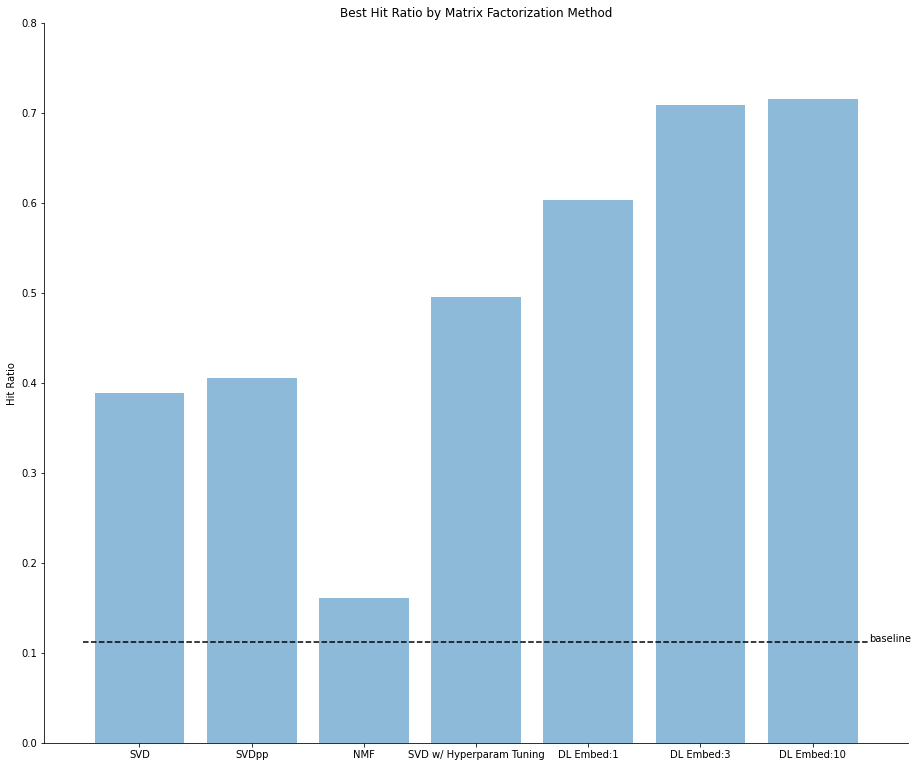

In [56]:
#Plot HR@10 with Cutoff
fig = plt.figure(figsize = (12,10))
ax = fig.add_axes([0,0,1,1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.bar(algo_list[1:], hr_cutoff_list[1:], alpha=0.5)
ax.hlines(hr_cutoff_list[0], xmin=-0.5, xmax = 6.5, color='black', linestyles='dashed', label='baseline')
ax.text(6.5, hr_cutoff_list[0], 'baseline')
ax.set_ylabel('Hit Ratio')
ax.set_ylim(0.0, 0.8)
ax.set_title('Best Hit Ratio by Matrix Factorization Method')
plt.show()

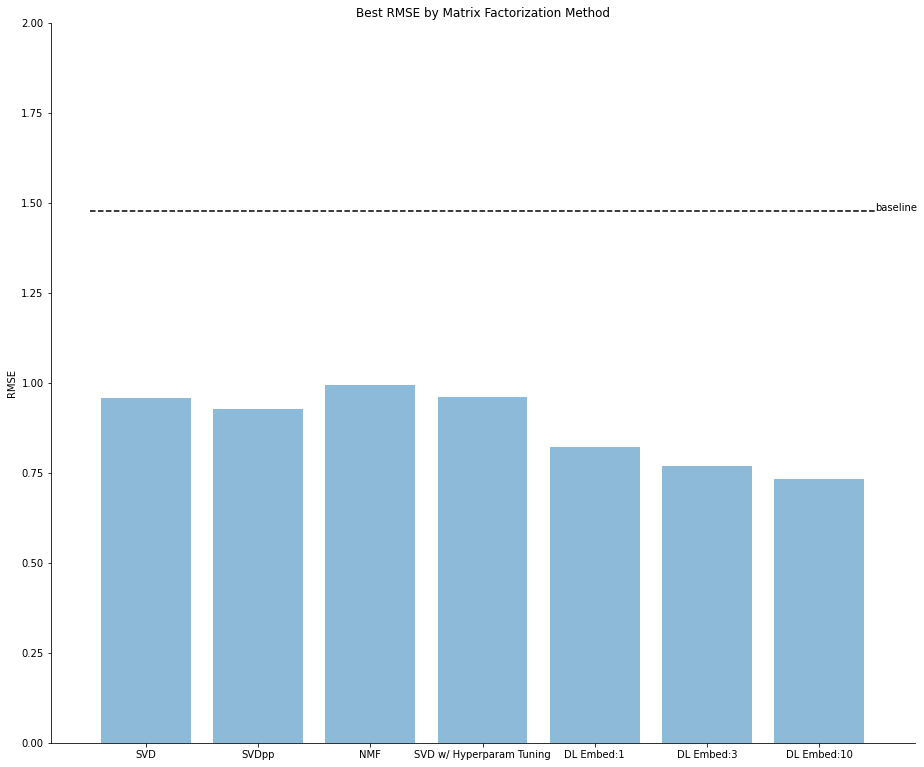

In [58]:
#Plot RMSE
fig = plt.figure(figsize = (12,10))
ax = fig.add_axes([0,0,1,1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.bar(algo_list[1:], rmse_list[1:], alpha=0.5)
ax.hlines(rmse_list[0], xmin=-0.5, xmax=6.5, color='black', linestyles='dashed', label='baseline')
ax.text(6.5, rmse_list[0], 'baseline')
ax.set_ylabel('RMSE')
ax.set_ylim(0.0, 2.0)
ax.set_title('Best RMSE by Matrix Factorization Method')
plt.show()

#### 6.) Switch to test data. 

In [35]:
#algo = SVD()
#Load our best model. 
algo = SVD(n_factors = best_n_factors, n_epochs = best_n_epochs, lr_all = best_lr_all, reg_all = best_reg_all)
# algo = SVD(n_factors = 50, n_epochs = 10, lr_all = 0.005, reg_all = 0.04)
algo.fit(train_data)
test_prediction = algo.test(test_data)

#Create our final dev_evaluation_pool using our best algo for diversifitcation swapping. 
sorted_test_evaluation_pool = sort_evaluation_pools(algo, test_evaluation_pools,sc_rankings, ranking_movieID)

#### 7.) Setup our diversification swapping. 

In [36]:
#Need to pass algo so that we can build the proper dictionary with predictions
topNPredicted_Split, nextNPredicted_Split, remainingNPredicted_Split = GetTopNSplitPools(sorted_test_evaluation_pool)

#### 7.) Run our diversification swapping and plot tradeoff. 

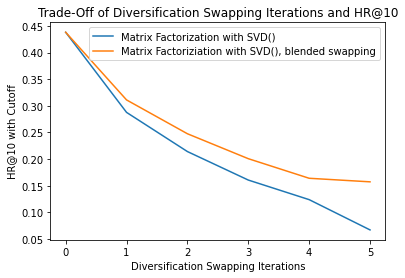

In [37]:
method, average_novelty, hit_rate, rmse, method_blended, average_novelty_blended, hit_rate_blended, rmse_blended, hit_rate_cutoff, hit_rate_cutoff_blended, swapping_iterations, swapping_iterations_blended = calcDiversityTradeoff(topNPredicted_Split, nextNPredicted_Split,remainingNPredicted_Split, test_df, test_prediction)

plt.plot(swapping_iterations, hit_rate_cutoff, label = 'Matrix Factorization with SVD()')
plt.plot(swapping_iterations_blended, hit_rate_cutoff_blended, label = 'Matrix Factoriziation with SVD(), blended swapping')
plt.title("Trade-Off of Diversification Swapping Iterations and HR@10")
plt.xlabel("Diversification Swapping Iterations")
plt.ylabel("HR@10 with Cutoff")
plt.legend(loc = 'best')

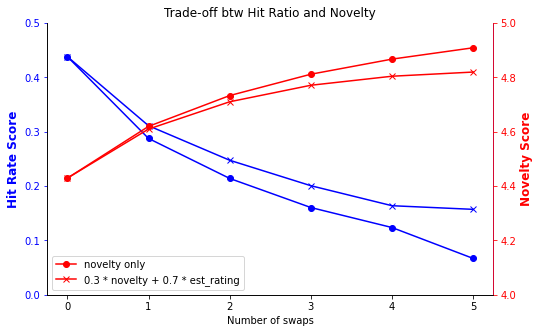

In [68]:
#Note we will use the non-blended version to tie to the methods used for Content Based, 
#despite better results. 

fig, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()
ax1.plot(swapping_iterations, hit_rate_cutoff, color='blue', marker='o', label='hit rate')
ax1.plot(swapping_iterations, hit_rate_cutoff_blended, color = 'blue', marker = 'x', label = 'hit rate blended')
ax2.plot(swapping_iterations, average_novelty, color='red', marker='o', label='novelty only')
ax2.plot(swapping_iterations, average_novelty_blended, color='red', marker='x', label='0.3 * novelty + 0.7 * est_rating')
ax1.set_title('Trade-off btw Hit Ratio and Novelty')
ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.set_xlabel('Number of swaps')
ax1.set_ylabel('Hit Rate Score', fontsize='large', fontweight='bold')
ax1.spines['right'].set_color('blue')
ax1.yaxis.label.set_color('blue')
ax1.tick_params(axis='y', colors='blue')
ax1.set_ylim(0.0, 0.5)
ax2.set_ylim(4.0, 5.0)
ax1.set_xticks(swapping_iterations)
ax2.set_ylabel('Novelty Score', fontsize='large', fontweight='bold')
ax2.spines['right'].set_color('red')
ax2.yaxis.label.set_color('red')
ax2.tick_params(axis='y', colors='red')
plt.legend(loc = 'lower left')
plt.show()